In [13]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az


df = pd.read_csv('iris.csv')
custom_petal_length = df['petal_length'].values
custom_sepal_length = df['sepal_length'].values
custom_petal_width = df['petal_width'].values


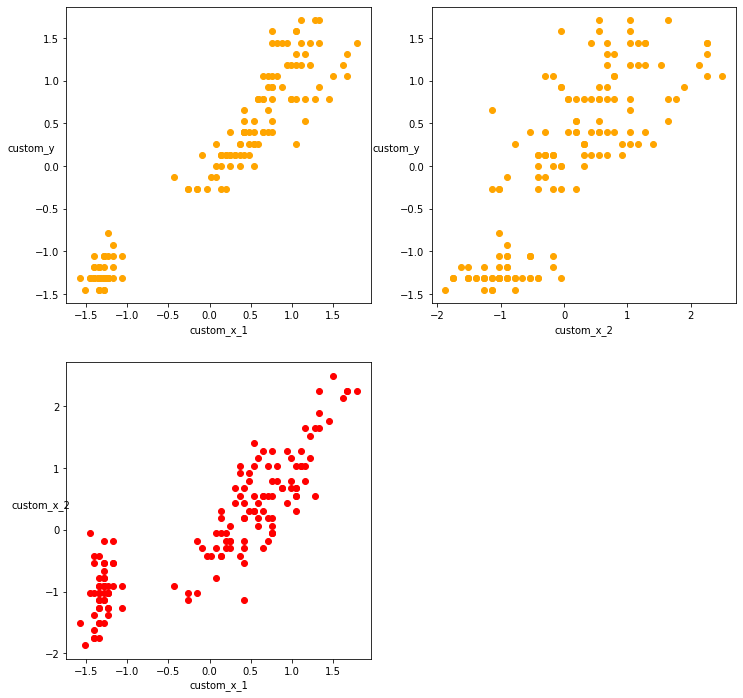

In [19]:
# Normalize Data
custom_x_1 = (custom_petal_length - custom_petal_length.mean()) / custom_petal_length.std()
custom_x_2 = (custom_sepal_length - custom_sepal_length.mean()) / custom_sepal_length.std()
custom_y = (custom_petal_width - custom_petal_width.mean()) / custom_petal_width.std()

custom_X = np.vstack((custom_x_1, custom_x_2)).T

# Scatter plot 
def custom_scatter_plot(x, y):
    plt.figure(figsize=(12, 12))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx + 1)
        plt.scatter(x_i, y,c='orange')
        plt.xlabel(f'custom_x_{idx + 1}')
        plt.ylabel(f'custom_y', rotation=0)

    plt.subplot(2, 2, idx + 2)
    plt.scatter(x[:, 0], x[:, 1], c='red')
    plt.xlabel(f'custom_x_{idx}')
    plt.ylabel(f'custom_x_{idx + 1}', rotation=0)

custom_scatter_plot(custom_X, custom_y)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

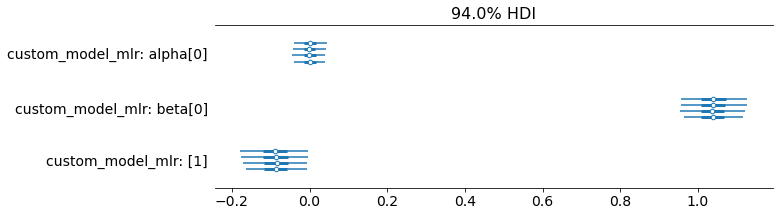

In [21]:
with pm.Model() as custom_model_mlr:
    custom_alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=10)
    custom_beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    custom_epsilon = pm.HalfCauchy('epsilon', 5)

    custom_mu = custom_alpha_tmp + pm.math.dot(custom_X, custom_beta)

    custom_alpha = pm.Deterministic('alpha', custom_alpha_tmp - pm.math.dot(custom_X.mean(axis=0, keepdims=True), custom_beta))

    custom_y_pred = pm.Normal('y_pred', mu=custom_mu, sigma=custom_epsilon, observed=custom_y)

    custom_idata_mlr = pm.sample(2000, return_inferencedata=True)

custom_varnames = ['alpha', 'beta']

az.plot_forest([custom_idata_mlr],
               model_names=['custom_model_mlr'],
               var_names=custom_varnames,
               combined=False, colors='cycle', figsize=(10, 3))


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

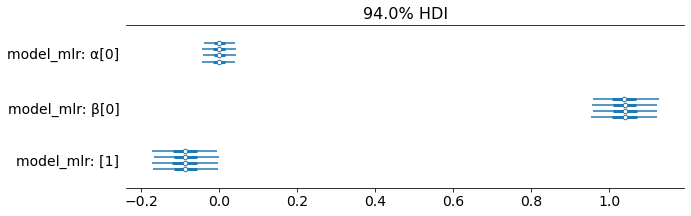

In [40]:
varnames = ['α', 'β']

az.plot_forest([idata_mlr],
               model_names=['model_mlr'],
               var_names=varnames,
               combined=False, colors='cycle', figsize=(10, 3))


<Axes: xlabel='β\n0', ylabel='β\n1'>

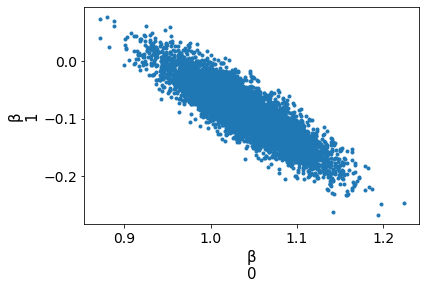

In [23]:

az.plot_pair(idata_mlr, var_names=['β'])

In [26]:
az.summary(idata_mlr, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],0.000,0.022,-0.041,0.043,0.000,0.0,6808.0,4930.0,1.0
β[0],1.039,0.045,0.957,1.125,0.001,0.0,4970.0,4521.0,1.0
β[1],-0.087,0.045,-0.171,-0.003,0.001,0.0,4817.0,4726.0,1.0


In [28]:
# Model for X1
with pm.Model() as custom_m_x1:
    custom_alpha_x1 = pm.Normal('custom_alpha_x1', mu=0, sigma=10)
    custom_beta_x1 = pm.Normal('custom_beta_x1', mu=0, sigma=10)
    custom_epsilon_x1 = pm.HalfCauchy('custom_epsilon_x1', 5)

    custom_mu_x1 = custom_alpha_x1 + custom_beta_x1 * custom_X[:, 0]

    custom_y_pred_x1 = pm.Normal('custom_y_pred_x1', mu=custom_mu_x1, sigma=custom_epsilon_x1, observed=custom_y)

    custom_idata_x1 = pm.sample(2000, return_inferencedata=True)

# Model for X2
with pm.Model() as custom_m_x2:
    custom_alpha_x2 = pm.Normal('custom_alpha_x2', mu=0, sigma=10)
    custom_beta_x2 = pm.Normal('custom_beta_x2', mu=0, sigma=10)
    custom_epsilon_x2 = pm.HalfCauchy('custom_epsilon_x2', 5)

    custom_mu_x2 = custom_alpha_x2 + custom_beta_x2 * custom_X[:, 1]

    custom_y_pred_x2 = pm.Normal('custom_y_pred_x2', mu=custom_mu_x2, sigma=custom_epsilon_x2, observed=custom_y)

    custom_idata_x2 = pm.sample(2000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [custom_epsilon_x1, custom_beta_x1, custom_alpha_x1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [custom_epsilon_x2, custom_beta_x2, custom_alpha_x2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


In [36]:
print("Analysis\n")
print("Given that Beta[1] values are close to zero, it indicates that the associated variable (sepal_length) has a limited impact on the model, rendering it redundant. In contrast, Petal Length acts as a confounding variable, generating a misleading correlation between Sepal Length and petal width. Moreover, a visual analysis of the pair plot of Betas and the scatter plot of X_1 and X_2 reveals a correlation between them, signifying multicollinearity, which is expected due to the presence of Petal Length as a confounding variable.")


Analysis

Given that Beta[1] values are close to zero, it indicates that the associated variable (sepal_length) has a limited impact on the model, rendering it redundant. In contrast, Petal Length acts as a confounding variable, generating a misleading correlation between Sepal Length and petal width. Moreover, a visual analysis of the pair plot of Betas and the scatter plot of X_1 and X_2 reveals a correlation between them, signifying multicollinearity, which is expected due to the presence of Petal Length as a confounding variable.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [custom_epsilon_x1x2, custom_beta2_x1x2, custom_beta1_x1x2, custom_alpha_x1x2]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 17 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

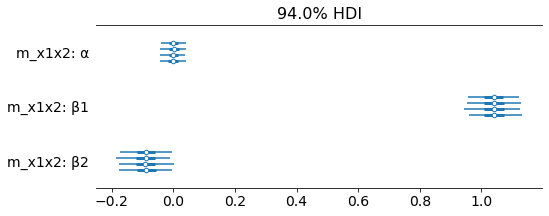

In [41]:


# Model for X1 and X2
with pm.Model() as custom_model_x1x2:
    custom_alpha_x1x2 = pm.Normal('custom_alpha_x1x2', mu=0, sigma=10)
    custom_beta1_x1x2 = pm.Normal('custom_beta1_x1x2', mu=0, sigma=10)
    custom_beta2_x1x2 = pm.Normal('custom_beta2_x1x2', mu=0, sigma=10)
    custom_epsilon_x1x2 = pm.HalfCauchy('custom_epsilon_x1x2', 5)

    custom_mu_x1x2 = custom_alpha_x1x2 + custom_beta1_x1x2 * custom_X[:, 0] + custom_beta2_x1x2 * custom_X[:, 1]

    custom_y_pred_x1x2 = pm.Normal('custom_y_pred_x1x2', mu=custom_mu_x1x2, sigma=custom_epsilon_x1x2, observed=custom_y)

    custom_idata_x1x2 = pm.sample(4000, tune=1000, return_inferencedata=True)  # Increased tune and draw iterations

# Plot forest plot
varnames_x1x2 = ['custom_alpha_x1x2', 'custom_beta1_x1x2', 'custom_beta2_x1x2']

varnames = ['α', 'β1', 'β2']

az.plot_forest([idata_x1x2],
               model_names=['m_x1x2'],
               var_names=varnames,
               combined=False, colors='cycle', figsize=(8, 3))



In [35]:
print ("Conclusion\n")
print("The forest plot reveals that when X_1 is introduced into the model, the coefficient B2 decreases substantially from 0.8 to nearly 0. On the other hand, the values of B1 exhibit minimal changes in both the Linear and Multilinear models. This suggests that it is safe to eliminate Sepal Length as a feature, as any variations in petal width attributed to Sepal Length can be adequately explained by changes in petal length. Therefore, model m_x1 represents the optimal choice for this particular scenario")


Conclusion

The forest plot reveals that when X_1 is introduced into the model, the coefficient B2 decreases substantially from 0.8 to nearly 0. On the other hand, the values of B1 exhibit minimal changes in both the Linear and Multilinear models. This suggests that it is safe to eliminate Sepal Length as a feature, as any variations in petal width attributed to Sepal Length can be adequately explained by changes in petal length. Therefore, model m_x1 represents the optimal choice for this particular scenario
